Inizio: 14:20

In [2]:
import pandas as pd;
data = pd.read_csv('./dataset.csv', sep=',')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Parte 1: Analisi

### 1

In [3]:
n_instances = data.index.size
completness = not data.isna().any().any()
values = data['Exited'].value_counts()

print(f'Numero di righe nel dataset: {n_instances}')
print(f'Il dataset è completo? {completness}')
print(f'Il dataset è bilanciato? {values}') 

# Considerazioni
# No, il dataset non è bilanciato

Numero di righe nel dataset: 10000
Il dataset è completo? True
Il dataset è bilanciato? Exited
0    7963
1    2037
Name: count, dtype: int64


### 2

In [4]:
data2 = data.copy()

data2['age_bins'] = pd.qcut(data2['Age'], q=5, precision=1, labels=['age_bin_1', 'age_bin_2', 'age_bin_3', 'age_bin_4', 'age_bin_5'])

churn_rate_younger = data2[data2['age_bins'] == 'age_bin_1']['Exited'].mean()
churn_rate_older = data2[data2['age_bins'] == 'age_bin_5']['Exited'].mean()

print(f'La probabilità che i clienti più giovani abbandonino la banca è di {churn_rate_younger:.2f}')
print(f'La probabilità che i clienti più anziani abbandonino la banca è di {churn_rate_older:.2f}')

# Considerazioni: 
# Sì, i clienti più giovani abbandonano la banca con una probabilità molto più alta.

La probabilità che i clienti più giovani abbandonino la banca è di 0.08
La probabilità che i clienti più anziani abbandonino la banca è di 0.46


/tmp/ipykernel_50781/1612212159.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data2_plot, x='Exited', y = 'balance_bins', orient='h', palette='viridis')


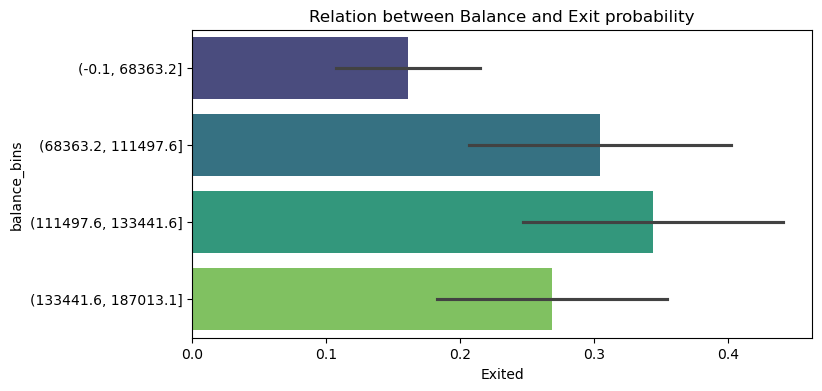

In [8]:
older_than_60_mask = data['Age'] > 60

data2_plot = data[older_than_60_mask].copy()
data2_plot['balance_bins'] = pd.qcut(data2_plot['Balance'], q=5, precision=1, duplicates='drop')

# Non è necessario: seaborn calcola in automatico la media
data2_plot['Exit_avg_per_balance'] = data2_plot.groupby('balance_bins')['Exited'].transform('mean')

import seaborn as sns
import matplotlib.pyplot as plt 

plt.figure(figsize=(8, 4))
plt.title('Relation between Balance and Exit probability')
sns.barplot(data2_plot, x='Exited', y = 'balance_bins', orient='h', palette='viridis')
plt.show()

# Considerazioni: No, non sembra esserci alcuna correlazione

In [9]:
pearson_corr = data2_plot['Balance'].corr(data2_plot['Exited'])
print(f"Pearson correlation tra Saldo e Abbandono: {pearson_corr:.3f}")

spearman_corr = data2_plot['Balance'].corr(data2_plot['Exited'], method='spearman')
print(f"Spearman correlation tra Saldo e Abbandono: {spearman_corr:.3f}")

Pearson correlation tra Saldo e Abbandono: 0.150
Spearman correlation tra Saldo e Abbandono: 0.136


### 3

In [28]:
data3 = data.copy()
data3['est_salary_bins'] = pd.cut(data3['EstimatedSalary'], bins=5, precision=1)

p_table = pd.pivot_table(data=data3, index='Gender', columns='est_salary_bins', values='CreditScore', aggfunc=['mean', 'count'])
display(p_table)

# Considerazioni
# La tabella pivot non mostra particolari differenze tra
# uomini e donne

mean                                         \
est_salary_bins (-188.4, 40007.8] (40007.8, 80003.9] (80003.9, 120000.1]   
Gender                                                                     
Female                 657.436219         651.474747          646.934899   
Male                   649.769731         650.378284          649.466117   

                                                                      count  \
est_salary_bins (120000.1, 159996.3] (159996.3, 199992.5] (-188.4, 40007.8]   
Gender                                                                        
Female                    646.401064           652.440357               878   
Male                      649.247855           652.460346              1077   

                                                                             \
est_salary_bins (40007.8, 80003.9] (80003.9, 120000.1] (120000.1, 159996.3]   
Gender                                                                        
Female                         891                 937                  940   
Male                          1142                1092                 1049   

                                      
est_salary_bins (159996.3, 199992.5]  
Gender                                
Female                           897  
Male                            1097

### 4

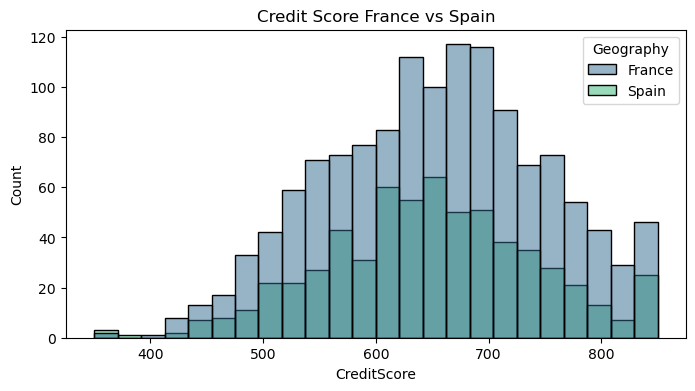

In [36]:
data4 = data.copy()

credit_balance_mask = (data4['HasCrCard'] == 1) & (data4['Balance'] > 100000)
data4_plot = data4[credit_balance_mask]
data4_plot = data4_plot[data4_plot['Geography'].isin(['Spain', 'France'])]

plt.figure(figsize=(8,4))
plt.title('Credit Score France vs Spain')
sns.histplot(data=data4_plot, x='CreditScore', hue='Geography', palette='viridis')
plt.show()

## Parte 2: Trasformazione e Predizione

In [38]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  str    
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  str    
 5   Gender           10000 non-null  str    
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), str(3)
memory usage: 1.1 MB


In [39]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

data = pd.read_csv('./dataset.csv', sep=',')

# RowNumber e CustomerId sono identificatori univoci cardinali. Non possiedno alcun potere predittivo,
# Anzi, potrebbero portare alcuni modelli ad overfittare più facilmente. Surname non è univoco
# ma non aggiunge comunque alcuna informazione

columns_to_drop = ['RowNumber', 'Surname', 'CustomerId']
data = data.drop(columns=columns_to_drop)

# Elimino istanze con valori nulli
data = data.dropna(how='any')

# Trasformo i valori categorici
categorical_cols = ['Geography', 'Gender']
data_transformed = pd.get_dummies(data, columns=categorical_cols)

X = data_transformed.drop(columns=['Exited'])
y = data_transformed['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=42, stratify=y)

#############################
DecisionTreeClassifier scores
#############################

(Train) f1 score: 1.0
(Train) Accuracy score: 1.0


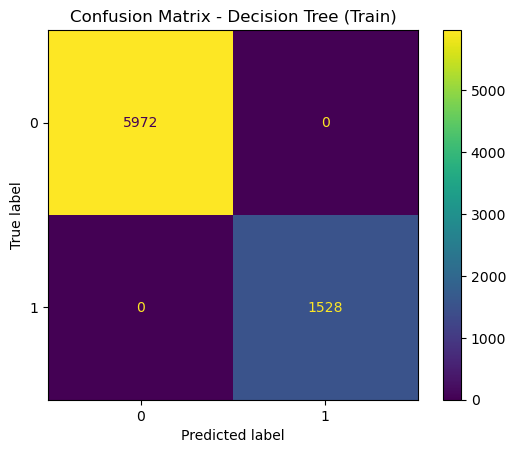

(Test) f1 score: 0.4936086529006883
(Test) Accuracy Score: 0.794


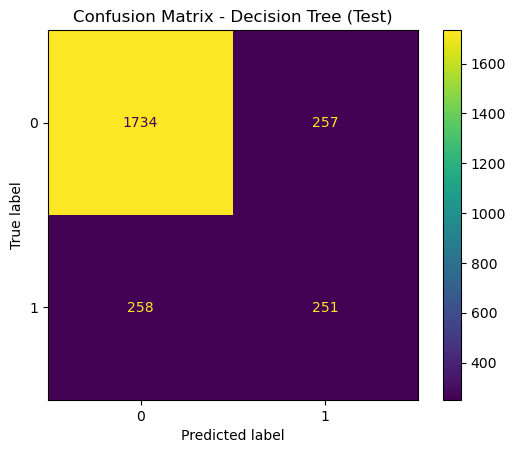

In [41]:
# Decision Tree

from sklearn.metrics import ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

y_pred_tree_train = tree_model.predict(X_train)
y_pred_tree_test = tree_model.predict(X_test)

f1_tree_train = f1_score(y_train, y_pred_tree_train)
acc_tree_train = accuracy_score(y_train, y_pred_tree_train)

f1_tree_test = f1_score(y_test, y_pred_tree_test)
acc_tree_test = accuracy_score(y_test, y_pred_tree_test)

print("#############################")
print("DecisionTreeClassifier scores")
print("#############################")
print()

print(f"(Train) f1 score: {f1_tree_train}")
print(f"(Train) Accuracy score: {acc_tree_train}")

ConfusionMatrixDisplay.from_estimator(tree_model, X_train, y_train)
plt.title('Confusion Matrix - Decision Tree (Train)')
plt.show()

print(f"(Test) f1 score: {f1_tree_test}")
print(f"(Test) Accuracy Score: {acc_tree_test}")
ConfusionMatrixDisplay.from_estimator(tree_model, X_test, y_test)
plt.title('Confusion Matrix - Decision Tree (Test)')
plt.show()

# Considerazioni
# Il train f1 score è accuracy è perfetto, mentre in Test cala drasticamente
# E' evidente che l'albero decisionale presenta il fenomeno dell'Overfitting
# Sarà necessario vincolare la profondità e il numero di foglie per ottenere
# un modello più robusto

#############################
KNeighbors Classifier scores
#############################

(Train) f1 score: 0.3157894736842105
(Train) Accuracy score: 0.8145333333333333


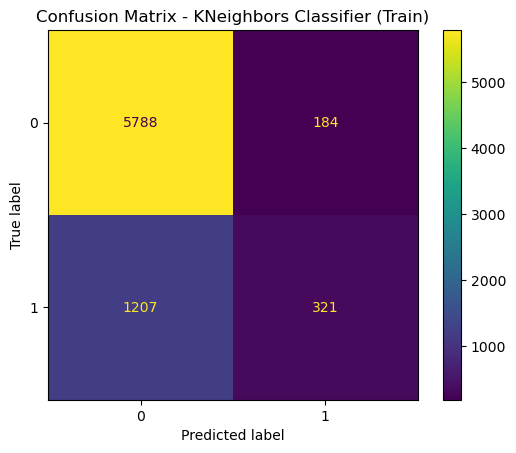

(Test) f1 score: 0.11538461538461539
(Test) Accuracy Score: 0.7608


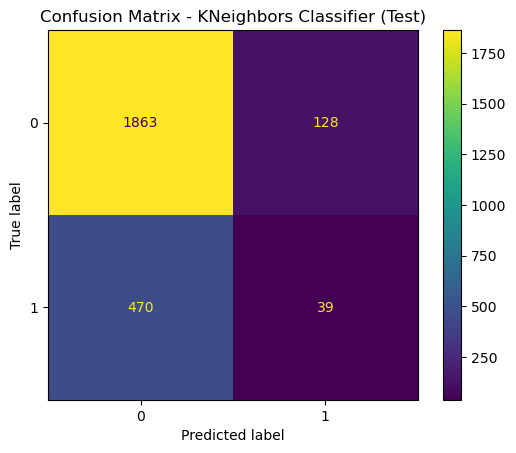

In [43]:
# KNeighbors
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

y_pred_knn_train = knn_model.predict(X_train)
y_pred_knn_test = knn_model.predict(X_test)

f1_knn_train = f1_score(y_train, y_pred_knn_train)
acc_knn_train = accuracy_score(y_train, y_pred_knn_train)

f1_knn_test = f1_score(y_test, y_pred_knn_test)
acc_knn_test = accuracy_score(y_test, y_pred_knn_test)

print("#############################")
print("KNeighbors Classifier scores")
print("#############################")
print()

print(f"(Train) f1 score: {f1_knn_train}")
print(f"(Train) Accuracy score: {acc_knn_train}")

ConfusionMatrixDisplay.from_estimator(knn_model, X_train, y_train)
plt.title('Confusion Matrix - KNeighbors Classifier (Train)')
plt.show()

print(f"(Test) f1 score: {f1_knn_test}")
print(f"(Test) Accuracy Score: {acc_knn_test}")
ConfusionMatrixDisplay.from_estimator(knn_model, X_test, y_test)
plt.title('Confusion Matrix - KNeighbors Classifier (Test)')
plt.show()

# Considerazioni
# Qui non è presente il fenomeno dell'overfitting perchè l'accuracy di Train e Test sono in linea
# con un peggioramento del test come atteso. Però è evidente che il KNeighbors non riesce a 
# performare bene: sono presenti molti falsi positivi

#############################
Dummy Classifier scores
#############################

(Train) f1 score: 0.0
(Train) Accuracy score: 0.7962666666666667


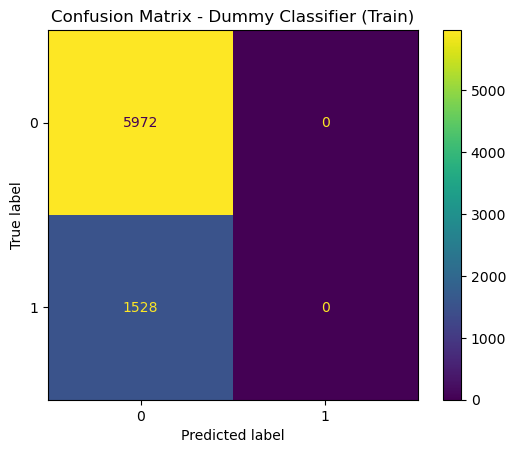

(Test) f1 score: 0.0
(Test) Accuracy Score: 0.7964


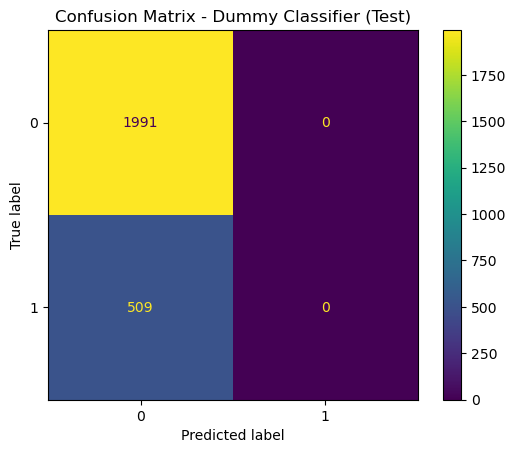

In [ ]:
# Dummy Classifier
from sklearn.dummy import DummyClassifier

dum_model = DummyClassifier()
dum_model.fit(X_train, y_train)

y_pred_dum_train = dum_model.predict(X_train)
y_pred_dum_test = dum_model.predict(X_test)

f1_dum_train = f1_score(y_train, y_pred_dum_train)
acc_dum_train = accuracy_score(y_train, y_pred_dum_train)

f1_dum_test = f1_score(y_test, y_pred_dum_test)
acc_dum_test = accuracy_score(y_test, y_pred_dum_test)

print("#############################")
print("Dummy Classifier scores")
print("#############################")
print()

print(f"(Train) f1 score: {f1_dum_train}")
print(f"(Train) Accuracy score: {acc_dum_train}")

ConfusionMatrixDisplay.from_estimator(dum_model, X_train, y_train)
plt.title('Confusion Matrix - Dummy Classifier (Train)')
plt.show()

print(f"(Test) f1 score: {f1_dum_test}")
print(f"(Test) Accuracy Score: {acc_dum_test}")
ConfusionMatrixDisplay.from_estimator(dum_model, X_test, y_test)
plt.title('Confusion Matrix - Dummy Classifier (Test)')
plt.show()

# Considerazioni
# 0.79 è l'accuracy che si ottiene con un Dummy Classifier che predice sempre Exited: false
# Ci serve come baseline per valutare le performance degli altri due modelli. Sia il Decision Tree
# che il Knn non hanno ottenuto un accuracy migliore di quella del Dummyb

### 2

In [ ]:
from sklearn.model_selection import cross_validate

cv_tree = cross_validate(tree_model, X_train, y_train, cv=10, scoring='accuracy')
acc_tree_test_cv = cv_tree['test_score'].mean()

cv_knn = cross_validate(knn_model, X_train, y_train, cv=10, scoring='accuracy')
acc_knn_test_cv = cv_knn['test_score'].mean()

cv_dum = cross_validate(dum_model, X_train, y_train, cv=10, scoring='accuracy')
acc_dum_test_cv = cv_dum['test_score'].mean()

acc_tree_delta = acc_tree_test_cv - acc_tree_test
acc_knn_delta = acc_knn_test_cv - acc_knn_test
acc_dum_delta = acc_dum_test_cv - acc_dum_test 

print(f"Delta dell'acc score per DecisionTreeClassifier: {acc_tree_delta:.2f}")
print(f"Delta dell'acc score per KNeighborsClassifier: {acc_knn_delta:.2f}")
print(f"Delta dell'acc score per DummyClassifier: {acc_dum_delta:.2f}")

# Considerazioni
# Il modello è stabile: l'accuracy è la stessa di quella calcolata senza KFold CV

Delta dell'acc score per DecisionTreeClassifier: -0.01
Delta dell'acc score per KNeighborsClassifier: -0.00
Delta dell'acc score per DummyClassifier: -0.00


### 3

In [ ]:
male_mask = X_test['Gender_Male']
female_mask = X_test['Gender_Female']

prob_male_churn = y_pred_tree_test[male_mask].mean()
prob_female_churn = y_pred_tree_test[female_mask].mean()

print(f"Probabilità che un cliente [Male] abbandoni la banca: {prob_male_churn:.2f}")
print(f"Probabilità che una cliente [Female] abbandoni la banca: {prob_female_churn:.2f}")

Probabilità che un cliente [Male] abbandoni la banca: 0.17
Probabilità che una cliente [Female] abbandoni la banca: 0.24


In [ ]:
from fairlearn.metrics import MetricFrame

mf = MetricFrame(
    metrics= {'accuracy': accuracy_score}, 
    y_true=y_test,
    y_pred=y_pred_tree_test,
    sensitive_features=X_test['Gender_Male']
)

mf.by_group

# Considerazioni: l'accuracy non è la stessa, ma sono molto vicine

,accuracy
Gender_Male,
False,0.760443
True,0.823662


In [60]:
X_unaware = data_transformed.drop(columns=['Exited', 'Gender_Male', 'Gender_Female'])
y_unaware = data_transformed['Exited']

X_train_unaware, X_test_unaware, y_train_unaware, y_test_unaware = train_test_split(X_unaware, 
                                                                                    y_unaware, 
                                                                                    train_size=.75, random_state=42, 
                                                                                    stratify=y_unaware)

tree_model_unaware = DecisionTreeClassifier()
tree_model_unaware.fit(X_train_unaware, y_train_unaware)

y_pred_tree_test_unaware = tree_model_unaware.predict(X_test_unaware)
acc_tree_test_unaware = accuracy_score(y_test_unaware, y_pred_tree_test_unaware)
delta_awareness = acc_tree_test_unaware - acc_tree_test
print(f"Accuracy score without Gender feature: {acc_tree_test_unaware}")
print(f"Accuracy delta: {delta_awareness:.2f}")

# Considerazioni:
# Il delta è molto piccolo

Accuracy score without Gender feature: 0.7896
Accuracy delta: -0.00


### 4

In [ ]:
data4 = data_transformed.copy()

data4['engineered'] = (data4['EstimatedSalary'] * data4['Tenure'] + data4['Balance']) / 2

X = data4.drop(columns=['Exited'])
y = data4['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=42, stratify=y)

tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

y_pred_tree_test = tree_model.predict(X_test)
acc_tree_test = accuracy_score(y_test, y_pred_tree_test)

print("#############################")
print("DecisionTreeClassifier scores")
print("#############################")
print()

print(f"(Test) Accuracy score: {acc_tree_test}")
# No, l'accuracy non migliora (0.79 precedentemente)


#############################
DecisionTreeClassifier scores
#############################

(Test) Accuracy score: 0.7844


In [ ]:
data4_2 = data_transformed.copy()

data4_2['engineered'] = (data4_2['EstimatedSalary'] * data4_2['Tenure'] + data4_2['Balance']) / 2
data4_2['engineered'] = pd.cut(data4_2['engineered'], bins=10, labels=range(10))

X = data4_2.drop(columns=['Exited'])
y = data4_2['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=42, stratify=y)

tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

y_pred_tree_test = tree_model.predict(X_test)
acc_tree_test = accuracy_score(y_test, y_pred_tree_test)

print("#############################")
print("DecisionTreeClassifier scores")
print("#############################")
print()

print(f"(Test) Accuracy score: {acc_tree_test}")
# No, l'accuracy non sembra cambiare

#############################
DecisionTreeClassifier scores
#############################

(Test) Accuracy score: 0.7928


### 5

In [ ]:
from sklearn.model_selection import GridSearchCV
data5 = data_transformed.copy()

params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3, 5, 10]
}

cv = GridSearchCV(DecisionTreeClassifier(), param_grid=params, scoring='accuracy').fit(X_train, y_train)

accuracy_delta_grid_search = cv.best_score_ - acc_tree_test

tree_accuracy_grid = cv.best_score_

print(f'Parametri migliori trovati per DecisionTreeClassifier: {cv.best_params_}')
print(f'Nuova accuracy con Grid Search: {tree_accuracy_grid:.2f}')
print(f'Delta di f1 score per il DecisionTreeClassifier: {accuracy_delta_grid_search}')

# I risultato mostrano che aver impostato i parametri di max_depth e criterion abbia 
# migliorato di molto l'accuracy

Parametri migliori trovati per DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': 5}
Nuova accuracy con Grid Search: 0.85
Delta di f1 score per il DecisionTreeClassifier: 0.05893333333333339


### 6

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler

preprocessing = ColumnTransformer(transformers=[
    ('discretizer', KBinsDiscretizer(n_bins=6, quantile_method='linear'), ['Balance', 'EstimatedSalary']),
    ('minmax_scaler', MinMaxScaler(), ['Tenure']),
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('model', DecisionTreeClassifier(criterion='entropy', max_depth=5))
])

pipeline.fit(X_train, y_train)

y_predicted = pipeline.predict(X_test)

pipeline1_accuracy = accuracy_score(y_test, y_predicted)
delta_with_grid_accuracy = pipeline1_accuracy - tree_accuracy_grid

print(f"Accuracy ottenuta con pipeline: {pipeline1_accuracy:.2f}")
print(f"Delta accuracy with grid search: {delta_with_grid_accuracy:.2f}")

Accuracy ottenuta con pipeline: 0.86
Delta accuracy with grid search: 0.01


/home/alesvale/miniconda3/envs/bdta_env/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:396: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


### 7

In [77]:
from sklearn.decomposition import TruncatedSVD

preprocessing7 = ColumnTransformer(transformers=[
    ('discretizer', KBinsDiscretizer(quantile_method='linear'), ['Balance', 'EstimatedSalary']),
    ('minmax_scaler', MinMaxScaler(), ['Tenure']),
], remainder='passthrough')

pipeline7 = Pipeline(steps=[
    ('preprocessing', preprocessing7),
    ('svd', TruncatedSVD()),
    ('model', DecisionTreeClassifier(criterion='entropy', max_depth=5))
])

params = {
    'svd__n_components': [2,4,6],
    'preprocessing__discretizer__n_bins': [3, 5, 7, 9]
}

cv = GridSearchCV(pipeline7, param_grid=params, scoring='accuracy').fit(X_train, y_train)

print(f"Parametri migliori trovati: {cv.best_params_}")
print(f"Score con GridSearch: {cv.best_score_}")
print(f"Delta con score precedente: {cv.best_score_ - pipeline1_accuracy}")

/home/alesvale/miniconda3/envs/bdta_env/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:396: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/alesvale/miniconda3/envs/bdta_env/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:396: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/alesvale/miniconda3/envs/bdta_env/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:396: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/alesvale/miniconda3/envs/bdta_env/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:396: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the n

Parametri migliori trovati: {'preprocessing__discretizer__n_bins': 5, 'svd__n_components': 6}
Score con GridSearch: 0.8213333333333332
Delta con score precedente: -0.039066666666666805


/home/alesvale/miniconda3/envs/bdta_env/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:396: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/alesvale/miniconda3/envs/bdta_env/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:396: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
